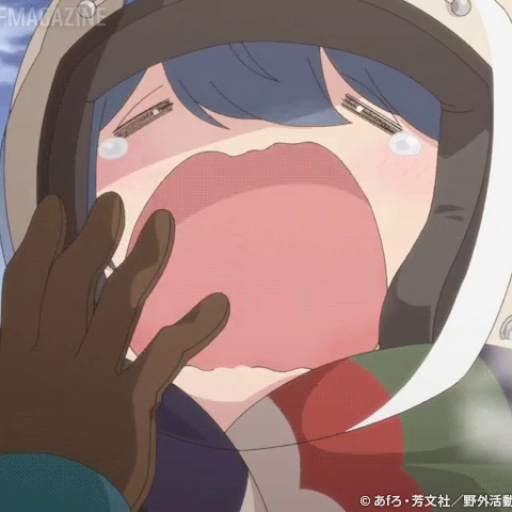

In [78]:
from torch.utils.data import Dataset
import pandas as pd
import os
from transformers import CLIPTokenizer
import decord
from einops import rearrange
from PIL import Image
import numpy as np
from torchvision import transforms

decord.bridge.set_bridge('torch')

class TuneAVideoMoreShotDataset(Dataset):
    def __init__(
        self,
        annotations_file: str, 
        video_dir: str,
        tokenizer: CLIPTokenizer,
        size: int = 512,
        n_sample_frames: int = 8,
        sample_start_idx: int = 0,
        sample_frame_rate: int = 1,
    ):
        self.df = pd.read_json(annotations_file, lines=True)
        self.video_dir = video_dir
        self.tokenizer = tokenizer # is this right place?

        self.n_sample_frames = n_sample_frames
        self.sample_start_idx = sample_start_idx
        self.sample_frame_rate = sample_frame_rate

        self.transform = transforms.Compose(
            [
                transforms.Resize(size),
                transforms.CenterCrop(size),
            ]
        )

    def __len__(self):
        return len(self.video_prompts)
    
    def __getitem__(self, idx):
        # process video
        video_path = os.path.join(self.video_dir, self.df.loc[idx,"video_file"])
        vr = decord.VideoReader(video_path)
        sample_index = list(range(self.sample_start_idx, len(vr), self.sample_frame_rate))[:self.n_sample_frames]
        video = vr.get_batch(sample_index)
        video = rearrange(video, "f h w c -> f c h w")
        video = (video / 255.0) # 0~255 -> 0~1
        video = (video * 2.0) - 1.0 # 0~1 -> -1~1
        video = self.transform(video)

        # process prompt
        prompt = self.df.loc[idx, "prompt"]
        prompt_ids = self.tokenizer(
            prompt,
            max_length=self.tokenizer.model_max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        ).input_ids[0]

        example = {
            "pixel_values": video,
            "prompt_ids" : prompt_ids
        }

        return example

dataset = TuneAVideoMoreShotDataset(
    annotations_file="../data/yurucamp_stamp/annotation.jsonl",
    video_dir="../data/yurucamp_stamp",
    tokenizer=CLIPTokenizer.from_pretrained("../checkpoints/dedede", subfolder="tokenizer"),
    size=512,
    n_sample_frames=8,
    sample_start_idx=0,
    sample_frame_rate=1,
)
img_t = dataset[0]["pixel_values"][7]
img_t = rearrange(img_t, "c h w -> h w c")
img_t = ((img_t + 1.0) / 2.0) * 255
img_t = img_t.numpy().astype(np.uint8)
Image.fromarray(img_t)

In [39]:
6 / 3

2.0